# Processing

scmdata has some support for processing `ScmRun` instances to calculate statistics of interest. Here we provide examples of how to use them.

## Load some data

For this demonstration, we are going to use MAGICC output from [RCMIP Phase 2] as available at [https://zenodo.org/record/4624566/files/data-processed-submission-database-hadcrut5-target-MAGICCv7.5.1.tar.gz?download=1](). Here we have just extracted the air temperature output for the SSPs from 1995 to 2100.

In [1]:
# NBVAL_IGNORE_OUTPUT
import scmdata.processing
from scmdata import ScmRun, run_append

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# NBVAL_IGNORE_OUTPUT
magicc_output = ScmRun("magicc-rcmip-phase-2-gsat-output.csv")
magicc_output

<scmdata.ScmRun (timeseries: 4800, timepoints: 106)>
Time:
	Start: 1995-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	     climate_model  ensemble_member        model region scenario unit  \
	0     MAGICCv7.5.1                0  unspecified  World   ssp585    K   
	1     MAGICCv7.5.1                1  unspecified  World   ssp585    K   
	2     MAGICCv7.5.1                2  unspecified  World   ssp585    K   
	3     MAGICCv7.5.1                3  unspecified  World   ssp585    K   
	4     MAGICCv7.5.1                4  unspecified  World   ssp585    K   
	...            ...              ...          ...    ...      ...  ...   
	4795  MAGICCv7.5.1              595  unspecified  World   ssp119    K   
	4796  MAGICCv7.5.1              596  unspecified  World   ssp119    K   
	4797  MAGICCv7.5.1              597  unspecified  World   ssp119    K   
	4798  MAGICCv7.5.1              598  unspecified  World   ssp119    K   
	4799  MAGICCv7.5.1              599  unspecified  World   ssp119  

## Crossing times

The first thing we do is show how to calculate the crossing times of a given threshold.

In [3]:
# NBVAL_IGNORE_OUTPUT
crossing_time_15 = scmdata.processing.calculate_crossing_times(
    magicc_output, threshold=1.5,
)
crossing_time_15

climate_model  ensemble_member  model        region  scenario  unit  variable                      
MAGICCv7.5.1   0                unspecified  World   ssp585    K     Surface Air Temperature Change    2025.0
               1                unspecified  World   ssp585    K     Surface Air Temperature Change    2029.0
               2                unspecified  World   ssp585    K     Surface Air Temperature Change    2024.0
               3                unspecified  World   ssp585    K     Surface Air Temperature Change    2023.0
               4                unspecified  World   ssp585    K     Surface Air Temperature Change    2023.0
                                                                                                        ...  
               595              unspecified  World   ssp119    K     Surface Air Temperature Change    2023.0
               596              unspecified  World   ssp119    K     Surface Air Temperature Change       NaN
               597  

The output is a `pd.Series`, which is useful for many other pieces of work.

For example, we could make a plot with e.g. seaborn.

<AxesSubplot:xlabel='1.5C crossing time', ylabel='Count'>

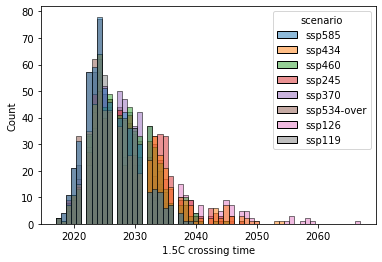

In [4]:
label = "1.5C crossing time"
pdf = crossing_time_15.reset_index().rename({0: label}, axis="columns")
sns.histplot(data=pdf, x=label, hue="scenario")

<AxesSubplot:xlabel='2.0C crossing time', ylabel='Count'>

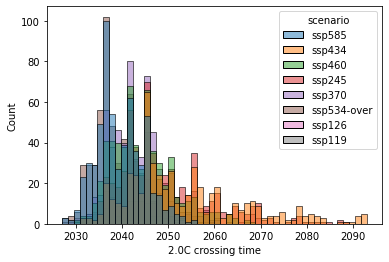

In [5]:
label = "2.0C crossing time"
crossing_time_20 = scmdata.processing.calculate_crossing_times(
    magicc_output, threshold=2.0,
)

pdf = crossing_time_20.reset_index().rename({0: label}, axis="columns")
sns.histplot(data=pdf, x=label, hue="scenario")

### Datetime output

If desired, data could be interpolated first before calculating the crossing times. In such cases, returning the output as datetime rather than year might be helpful.

In [6]:
scmdata.processing.calculate_crossing_times(
    magicc_output.resample("MS"), threshold=2.0, return_year=False,
)

climate_model  ensemble_member  model        region  scenario  unit  variable                      
MAGICCv7.5.1   0                unspecified  World   ssp585    K     Surface Air Temperature Change   2042-02-01
               1                unspecified  World   ssp585    K     Surface Air Temperature Change   2041-10-01
               2                unspecified  World   ssp585    K     Surface Air Temperature Change   2035-11-01
               3                unspecified  World   ssp585    K     Surface Air Temperature Change   2035-09-01
               4                unspecified  World   ssp585    K     Surface Air Temperature Change   2036-01-01
                                                                                                         ...    
               595              unspecified  World   ssp119    K     Surface Air Temperature Change          NaT
               596              unspecified  World   ssp119    K     Surface Air Temperature Change          